In [1]:
%load_ext autoreload
%autoreload 2

In [142]:
import os
import cv2
import re
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import librosa

from PIL import Image
import IPython.display as ipd

from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from utils import io, train, eval
from utils import feature_engineering as fe

In [143]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

- 02-01-01 ep separation 19718
- 2-04-04 ep separation 19466
- 3-04-03 ep separation 19435

In [144]:
episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

In [145]:
# kermit_pixels_dict = {}

# for ep in episode_names:
#     cap = io.load_video(video_paths[ep])
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     kermit_pixels_dict[ep] = []
    
#     for i in tqdm(range(frame_count)):
#         _, image = cap.read()

#         image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         kermit_pixels_num = ((image_hsv[:, :, 0] >= 25) & (image_hsv[:, :, 0] <= 50)).sum()
#         kermit_pixels_dict[ep].append(kermit_pixels_num)

# for ep in episode_names:
#     kermit_pixels_dict[ep] = kermit_pixels_dict[ep][1:]

In [77]:
# pickle.dump(kermit_pixels_dict, open("../data/features/kermit_pixels.pkl", "wb"))

In [5]:
# ep_dfs = []
# for ep in episode_names:
#     rec, sr = librosa.load(video_paths[ep], sr=None)

#     frame_size_ms = 400
#     hop_length = int(1/25 * sr)
#     frame_length = int(frame_size_ms / 1000 * sr)
    
#     desired_len = len(gt_df[gt_df.episode==ep])
#     zcr = librosa.feature.zero_crossing_rate(y=rec, frame_length=frame_length, hop_length=hop_length)
#     zcr = np.pad(zcr, pad_width=((0, 0), (0, desired_len - zcr.shape[1]))).flatten()

#     rms = librosa.feature.rms(y=rec, frame_length=frame_length, hop_length=hop_length)
#     rms = np.pad(rms, pad_width=((0, 0), (0, desired_len - rms.shape[1]))).flatten()

#     mfcc = librosa.feature.mfcc(y=rec, sr=sr, n_fft=frame_length, hop_length=hop_length)
#     mfcc = np.pad(mfcc, pad_width=((0, 0), (0, desired_len - mfcc.shape[1])))

#     biggest_mags, freqs = fe.get_biggest_stft_peaks(rec, sr, frame_length, hop_length, top_k=5)
#     freqs = np.pad(freqs, pad_width=((0, desired_len - freqs.shape[0]), (0, 0)))
#     biggest_mags = np.pad(biggest_mags, pad_width=((0, desired_len - biggest_mags.shape[0]), (0, 0)))

#     ep_df = pd.DataFrame()

#     ep_df['zcr'] = zcr
#     ep_df['rms'] = rms
    
#     for i in range(mfcc.shape[0]):
#         ep_df[f'mfcc_{i}'] = mfcc[i]

#     for i in range(biggest_mags.shape[1]):
#         ep_df[f'freq_{i}'] = freqs[:, i]
#         ep_df[f'biggest_mag_{i}'] = biggest_mags[:, i]
    
#     # ep_df['episode'] = ep
#     ep_dfs.append(ep_df)

# feat_df = pd.concat(ep_dfs)
# # feat_df['episode_split'] = gt_df['episode_split']

C:\Users\Alina\AppData\Local\Temp\ipykernel_13628\3733179146.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  rec, sr = librosa.load(video_paths[ep], sr=None)
c:\Users\Alina\anaconda3\envs\SimilarityModeling\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Alina\AppData\Local\Temp\ipykernel_13628\3733179146.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  rec, sr = librosa.load(video_paths[ep], sr=None)
c:\Users\Alina\anaconda3\envs\SimilarityModeling\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Alina\AppData\Local\Temp\ipykernel_13628\3733

In [146]:
# feat_df.to_csv('../data/audio_features.csv', index=False)
feat_df = pd.read_csv('../data/features/audio_features.csv')

In [147]:
## merge feat df and gt df on index
final_df = feat_df
for c in gt_df.columns:
    final_df.loc[:, c] = gt_df[c].values

In [148]:
# add kermit pixels
# final_df = gt_df.copy()

kermit_pixels = pickle.load(open("../data/features/kermit_pixels.pkl", "rb"))

final_df['kermit_pixels'] = 0

for ep in episode_names:
    final_df.loc[final_df['episode'] == ep, f'kermit_pixels'] = kermit_pixels[ep]

In [149]:
# add all kermit pixels
# final_df = gt_df.copy()

kermit_pixels = pickle.load(open("../data/features/kermit_pixels_all.pkl", "rb"))
kermit_pixels['Muppets-02-01-01'].keys()

final_df['kermit_pixels'] = 0

for ep in episode_names:
    for feat in kermit_pixels[ep].keys():
        final_df.loc[final_df['episode'] == ep, feat] = kermit_pixels[ep][feat]

In [150]:
# add hue features
flow_feat_dict = pickle.load(open("../data/features/flow_features.pkl", "rb"))

for ep in episode_names:
    current_ep_feats = flow_feat_dict[ep]
    for feat_name, feats in current_ep_feats.items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feats[1:]
    

In [151]:
# add hue features
hue_feat_list = pickle.load(open("../data/features/hue_feat_list_full.pkl", "rb"))

for ep in episode_names:
    current_hue_feat_list = hue_feat_list[ep]['hue_list']
    for i, col_name in enumerate(['percentage_full', 'hue_full']):
        for k in range(current_hue_feat_list.shape[1]):
            final_df.loc[final_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

In [152]:
hue_feat_list = pickle.load(open("../data/features/hue_feat_list_optical_flow_foreground.pkl", "rb"))

for ep in episode_names:
    current_hue_feat_list = hue_feat_list[ep]['hue_list']
    for i, col_name in enumerate(['percentage_for', 'hue_for']):
        for k in range(current_hue_feat_list.shape[1]):
            final_df.loc[final_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

In [153]:
hue_feat_list = pickle.load(open("../data/features/hue_feat_list_background.pkl", "rb"))

for ep in episode_names:
    current_hue_feat_list = hue_feat_list[ep]['hue_list']
    for i, col_name in enumerate(['percentage_back', 'hue_back']):
        for k in range(current_hue_feat_list.shape[1]):
            final_df.loc[final_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

# CV

In [154]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [155]:
split_col = 'episode_split'
final_df = final_df.fillna(0)
split_ids = final_df[split_col].unique()

# train_cols = ['zcr', 'rms'] + [c for c in final_df.columns if 'biggest_mag' in c or 'freq' in c]
# train_cols = ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)] + [f'hue_{i}' for i in range(5)] + [f'percentage_{i}' for i in range(5)]
# train_cols = ['zcr', 'rms'] + [c for c in final_df.columns if 'biggest_mag' in c or 'freq' in c] + [c for c in final_df.columns if 'hue' in c] + [c for c in final_df.columns if 'percentage' in c]
train_cols = ['zcr', 'rms', 'mean_flow', 'std_dev_flow'] + [c for c in final_df.columns if 'biggest_mag' in c or 'freq' in c] + [c for c in final_df.columns if 'hue' in c] + [c for c in final_df.columns if 'percentage' in c] + [c for c in final_df.columns if 'kermit' in c]
print(train_cols)
target_col = 'Kermit'

train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})
    

['zcr', 'rms', 'mean_flow', 'std_dev_flow', 'freq_0', 'biggest_mag_0', 'freq_1', 'biggest_mag_1', 'freq_2', 'biggest_mag_2', 'freq_3', 'biggest_mag_3', 'freq_4', 'biggest_mag_4', 'hue_full_0', 'hue_full_1', 'hue_full_2', 'hue_full_3', 'hue_full_4', 'hue_for_0', 'hue_for_1', 'hue_for_2', 'hue_for_3', 'hue_for_4', 'hue_back_0', 'hue_back_1', 'hue_back_2', 'hue_back_3', 'hue_back_4', 'percentage_full_0', 'percentage_full_1', 'percentage_full_2', 'percentage_full_3', 'percentage_full_4', 'percentage_for_0', 'percentage_for_1', 'percentage_for_2', 'percentage_for_3', 'percentage_for_4', 'percentage_back_0', 'percentage_back_1', 'percentage_back_2', 'percentage_back_3', 'percentage_back_4', 'kermit_pixels', 'num_kermit_pixels_foreground', 'num_kermit_pixels_background', 'kermit_pixels_ratio']


In [156]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [50, 100]
            # 'clf__n_estimators': [10, 50],
            # 'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [50, 100]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

Train splits: [0, 3, 2, 5, 4], Test split: 1
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 3, 2, 5, 4], Test split: 0
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 2, 5, 4], Test split: 3
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 5, 4], Test split: 2
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 2, 4], Test split: 5
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 2, 5], Test split: 4
Training RandomForest...
Training DecisionTree...
Training KNN...


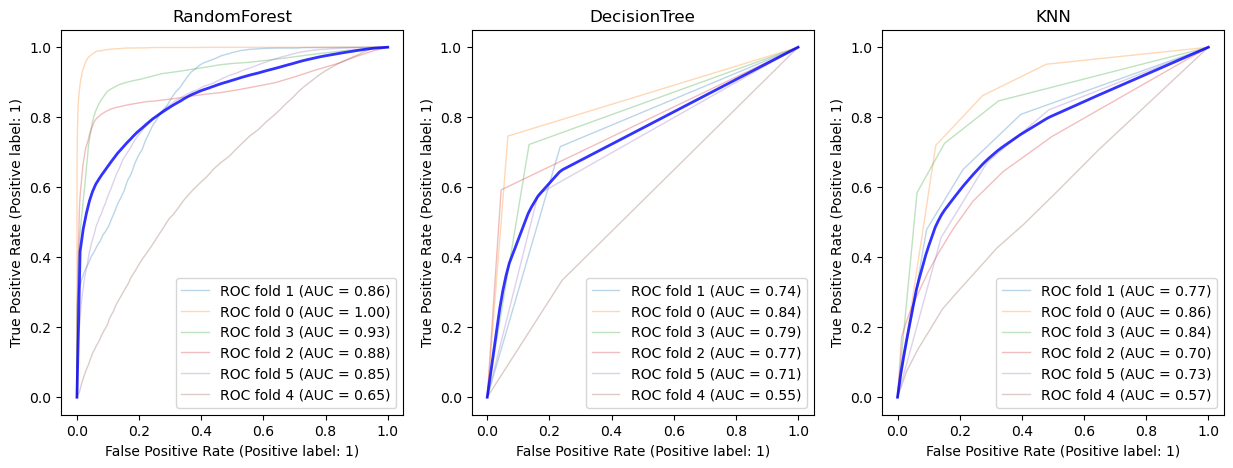

In [157]:
clf_dict_outer = {cfg['model_name']:[] for cfg in clf_config}
tprs_dict = {cfg['model_name']:[] for cfg in clf_config}

mean_fpr = np.linspace(0, 1, 100)

eval_dfs = []

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for test_split_id in split_ids:
    inner_cv_splits = [s for s in split_ids if s != test_split_id]

    test_X = final_df[final_df.episode_split==test_split_id][train_cols]
    # TODO comment out for num features > 1
    # test_X = np.array(test_X).reshape(-1, 1)
    test_y = final_df[final_df.episode_split==test_split_id][target_col]

    print(f'Train splits: {inner_cv_splits}, Test split: {test_split_id}')

    for i, cfg in enumerate(clf_config):
        print(f'Training {cfg["model_name"]}...')
        model_name = cfg['model_name']
        clf = cfg['model']
        clf = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
        param_grid = cfg['param_grid']

        # find best hyperparams on validation set with inner CV
        # train model with best hyperparams on full inner CV set / outer CV train set
        clf_dict = {}
        inner_df = final_df[final_df.episode_split.isin(inner_cv_splits)]
        train_X = inner_df[train_cols]
        train_y = inner_df[target_col]

        # TODO comment out for num features > 1
        # train_X = np.array(train_X).reshape(-1, 1)

        ps = PredefinedSplit(inner_df[split_col].values)
        grid_search = GridSearchCV(clf, param_grid, cv=ps, n_jobs=-1, scoring=['f1', 'precision', 'recall', 'balanced_accuracy'], refit='f1')
        
        grid_search.fit(train_X, train_y)

        clf_dict['model_name'] = model_name
        clf_dict['model'] = grid_search.best_estimator_
        clf_dict['params'] = grid_search.best_params_
        clf_dict['f1_inner'] = grid_search.best_score_
        clf_dict['cv_results_'] = grid_search.cv_results_

        clf_dict_outer[model_name].append(clf_dict)

        # evaluate model with outer CV test set
        predict_y = clf_dict['model'].predict(test_X)
        eval_dict = eval.eval_prediction(test_y, predict_y, model_name=model_name, config=train_cfg)

        eval_dict['target'] = target_col
        eval_dict['test_split'] = test_split_id

        eval_dfs.append(pd.DataFrame.from_dict(eval_dict, orient='index').T)

        # plot ROC curve (wiki definition)
        viz = RocCurveDisplay.from_estimator(
            clf_dict['model'],
            test_X,
            test_y,
            name=f"ROC fold {test_split_id}",
            alpha=0.3,
            lw=1,
            ax=axes[i]
        )

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs_dict[model_name].append(interp_tpr)

        pd.concat(eval_dfs).to_csv("../data/eval/DT_Kermit_all_feat_temp.csv")
        pickle.dump(clf_dict_outer, open("../data/models/DT_Kermit_all_feat_temp.pkl", "wb"))

eval_df = pd.concat(eval_dfs) 

for i, cfg in enumerate(clf_config):
    mean_tpr = np.mean(tprs_dict[cfg['model_name']], axis=0)
    mean_tpr[-1] = 1.0
    axes[i].plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f"Mean ROC ({model_name})",
        lw=2,
        alpha=0.8,
    )
    axes[i].set(title=f"{cfg['model_name']}")

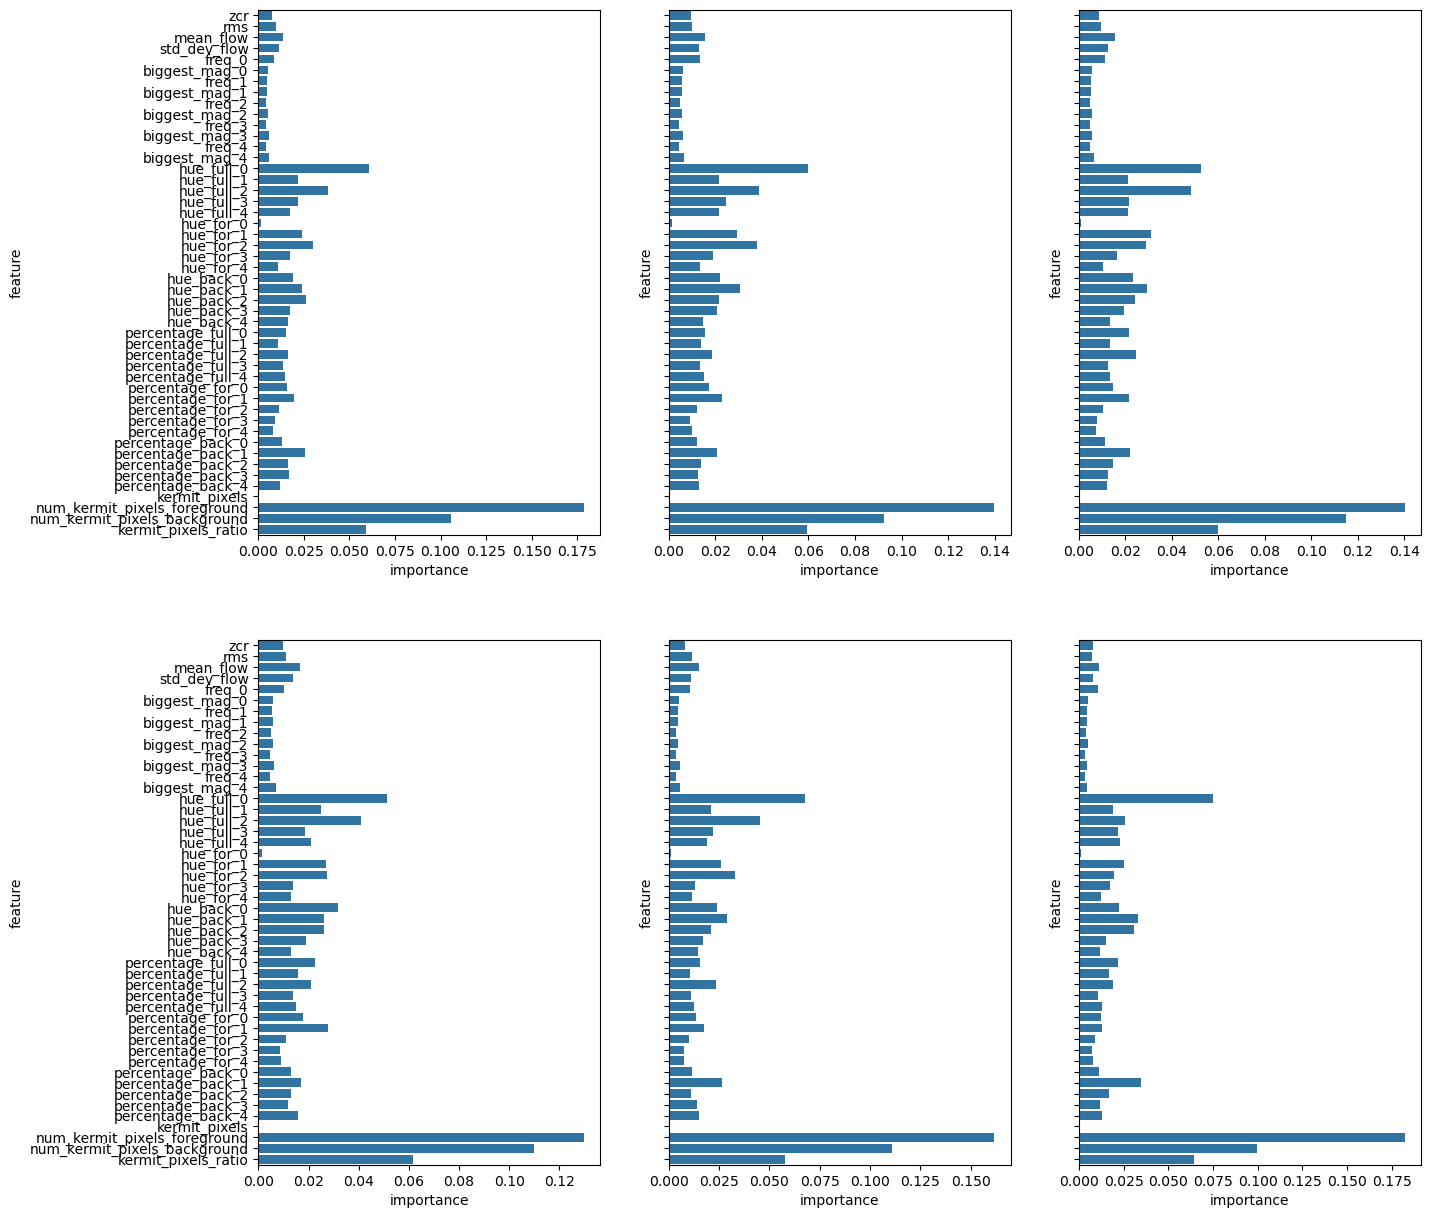

In [158]:
# feature importance for kermit
_, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()

for i, model_dict in enumerate(clf_dict_outer['RandomForest']):
    # print(i)
    forest = model_dict['model']['clf']
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=train_cols)
    df = pd.DataFrame(forest_importances).reset_index(drop=False)
    df.columns = ['feature', 'importance']
    sns.barplot(y='feature', x='importance', data=df, ax=axes[i])
    if i not in [0, 3]:
        axes[i].set(yticklabels=[])

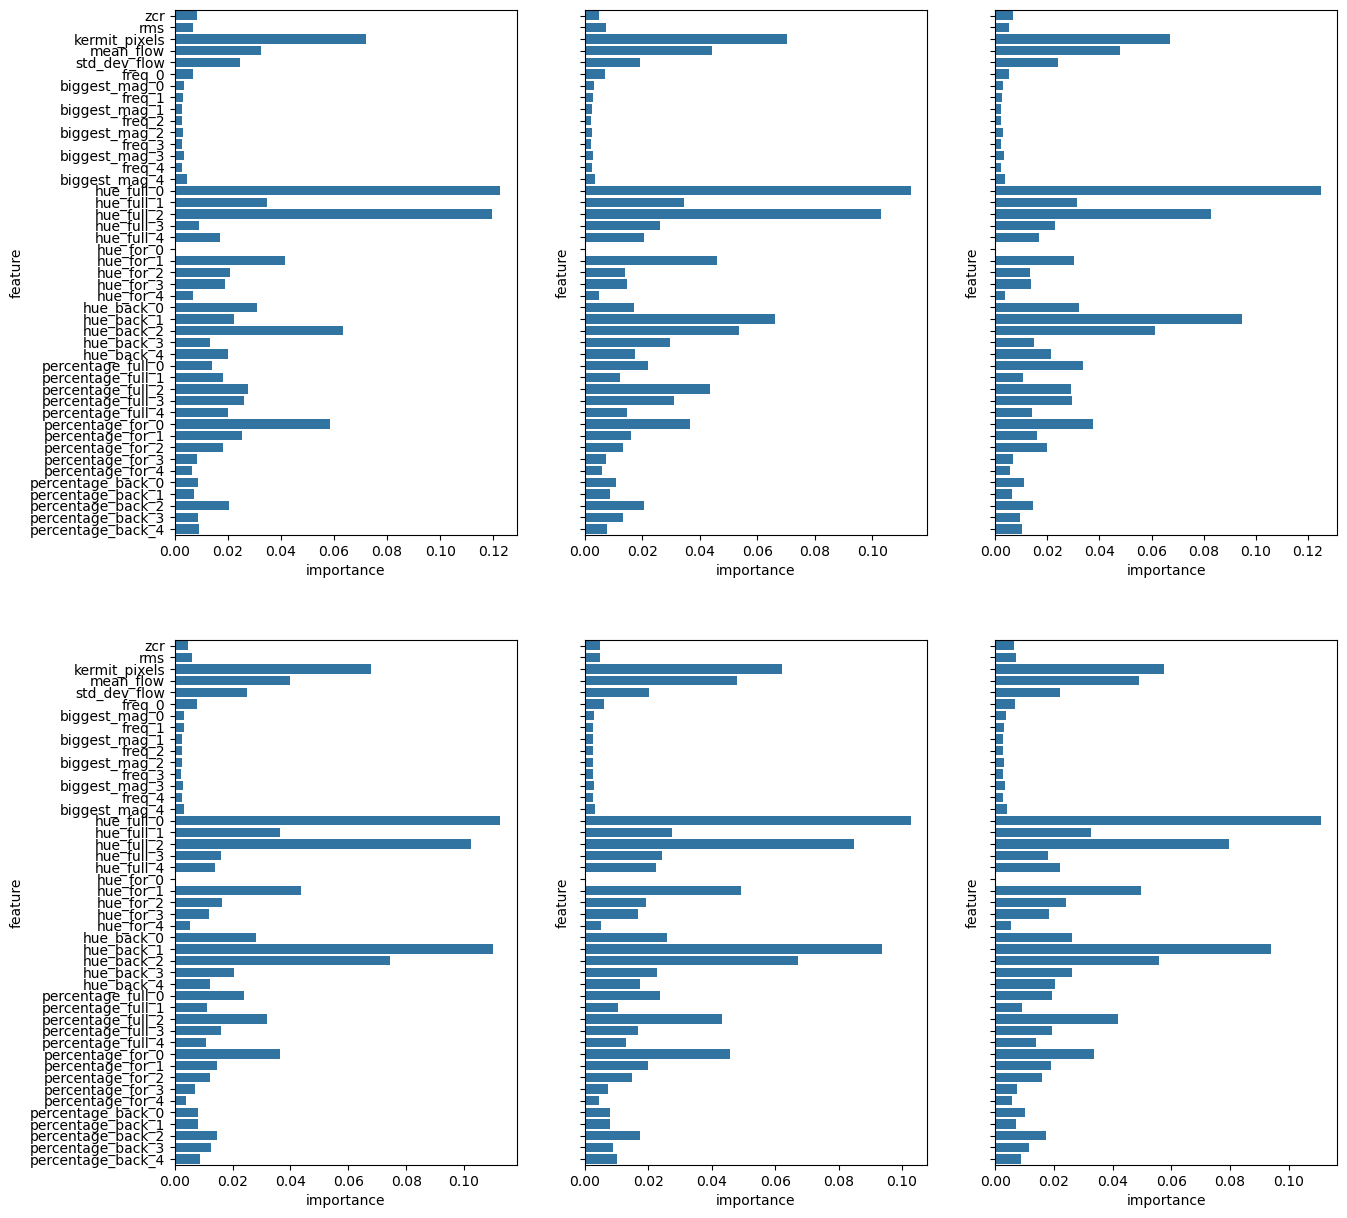

In [101]:
# feature importance for gentlemen
_, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()

for i, model_dict in enumerate(clf_dict_outer['RandomForest']):
    # print(i)
    forest = model_dict['model']['clf']
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=train_cols)
    df = pd.DataFrame(forest_importances).reset_index(drop=False)
    df.columns = ['feature', 'importance']
    sns.barplot(y='feature', x='importance', data=df, ax=axes[i])
    if i not in [0, 3]:
        axes[i].set(yticklabels=[])

In [72]:
eval_df

,model,config,precision,recall,tpr,fpr,f1,support,target,test_split
0,RandomForest,"percentage_for, kermit_pixels, std_dev_flow, h...",1.0,0.086078,0.086078,0.0,0.158511,None,StatlerWaldorf,1
0,DecisionTree,"percentage_for, kermit_pixels, std_dev_flow, h...",0.814706,0.207335,0.207335,0.003427,0.330549,None,StatlerWaldorf,1
0,KNN,"percentage_for, kermit_pixels, std_dev_flow, h...",0.734783,0.505988,0.505988,0.013274,0.599291,None,StatlerWaldorf,1
0,RandomForest,"percentage_for, kermit_pixels, std_dev_flow, h...",0.954286,0.360691,0.360691,0.000432,0.523511,None,StatlerWaldorf,0
0,DecisionTree,"percentage_for, kermit_pixels, std_dev_flow, h...",0.375494,0.410367,0.410367,0.017081,0.392157,None,StatlerWaldorf,0
0,KNN,"percentage_for, kermit_pixels, std_dev_flow, h...",0.850267,0.343413,0.343413,0.001514,0.489231,None,StatlerWaldorf,0
0,RandomForest,"percentage_for, kermit_pixels, std_dev_flow, h...",0.954098,0.875188,0.875188,0.001489,0.912941,None,StatlerWaldorf,3
0,DecisionTree,"percentage_for, kermit_pixels, std_dev_flow, h...",0.673969,0.786466,0.786466,0.013457,0.725885,None,StatlerWaldorf,3
0,KNN,"percentage_for, kermit_pixels, std_dev_flow, h...",0.743758,0.851128,0.851128,0.010372,0.793829,None,StatlerWaldorf,3
0,RandomForest,"percentage_for, kermit_pixels, std_dev_flow, h...",0.950156,0.776081,0.776081,0.000849,0.854342,None,StatlerWaldorf,2


In [131]:
for model in clf_dict_outer['RandomForest']:
    print(model['params'])

{'clf__max_depth': 100, 'clf__n_estimators': 50}
{'clf__max_depth': 100, 'clf__n_estimators': 100}
{'clf__max_depth': 50, 'clf__n_estimators': 100}
{'clf__max_depth': 100, 'clf__n_estimators': 100}
{'clf__max_depth': 50, 'clf__n_estimators': 100}
{'clf__max_depth': 50, 'clf__n_estimators': 100}


In [132]:
eval_df.to_csv("../data/eval/Kermit_all.csv")
pickle.dump(clf_dict_outer, open("../data/models/Kermit_all.pkl", "wb"))

In [159]:
n = 5
precision_dict = {}
recall_dict = {}
f1_dict = {}
fpr_dict = {}

for model_name in clf_dict_outer.keys():
    precision_dict[model_name] = []
    recall_dict[model_name] = []
    f1_dict[model_name] = []
    fpr_dict[model_name] = []

    for model in clf_dict_outer[model_name]:
        for i in range(n):
            scores = model['cv_results_']
            precision_dict[model_name] += scores[f'split{i}_test_precision'].tolist()
            recall_dict[model_name] += scores[f'split{i}_test_recall'].tolist()
            f1_dict[model_name] += scores[f'split{i}_test_f1'].tolist()

            tnr = 2*scores[f'split{i}_test_balanced_accuracy'] - scores[f'split{i}_test_recall']
            fpr_dict[model_name] += (1 - tnr).tolist()

        precision_dict[model_name] += eval_df[eval_df.model==model_name].precision.tolist()
        recall_dict[model_name] += eval_df[eval_df.model==model_name].recall.tolist()
        f1_dict[model_name] += eval_df[eval_df.model==model_name].f1.tolist()

        fpr_dict[model_name] += eval_df[eval_df.model==model_name].fpr.tolist()

tpr_dict = recall_dict


In [160]:
def plot_precision_recall_curve(precision_dict, recall_dict, model_name, title):
    _, ax = plt.subplots(figsize=(8, 8))
    for model_name in clf_dict_outer.keys():
        sns.lineplot(x=precision_dict[model_name], y=recall_dict[model_name], label=model_name, ax=ax)
    ax.set(xlabel='Precision', ylabel='Recall', title=title)

In [161]:
def plot_roc_curve(fpr_dict, tpr_dict, model_name, title):
    _, ax = plt.subplots(figsize=(8, 8))
    for model_name in clf_dict_outer.keys():
        sns.scatterplot(x=fpr_dict[model_name], y=tpr_dict[model_name], label=model_name, ax=ax, alpha=0.5)

        fpr_list = fpr_dict[model_name] + [1, 2, 3, 4, 0]
        tpr_list = tpr_dict[model_name] + [1, 1, 1, 1, 0]

        X = np.array([fpr_list, tpr_list]).T

        coeffs = np.polyfit(X[:, 0], X[:, 1], 3)
        poly_func = np.poly1d(coeffs)

        x_plot = np.linspace(0, 1, 100)
        y_plot = poly_func(x_plot)

        sns.lineplot(x=x_plot, y=y_plot, label=model_name, ax=ax)

    ax.set(xlabel='FPR', ylabel='TPR', title=title)
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray', ax=ax, linestyle='--')

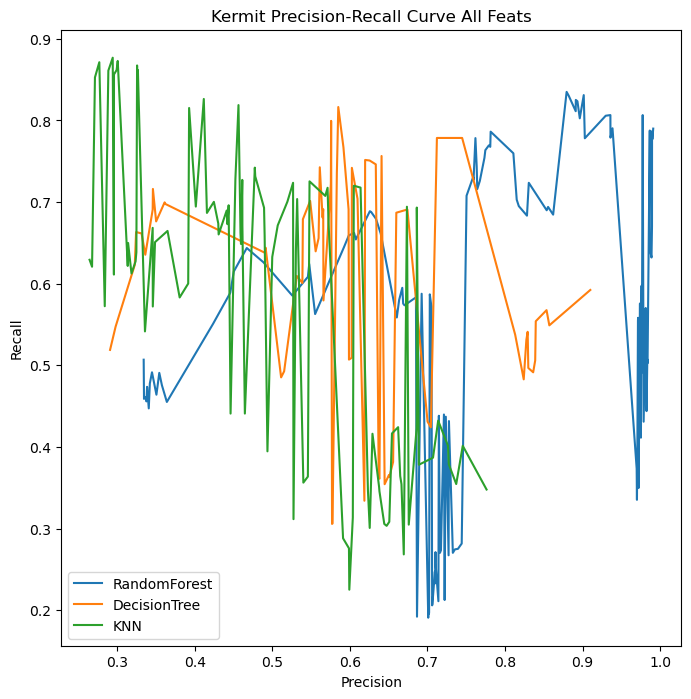

In [162]:
plot_precision_recall_curve(precision_dict, recall_dict, model_name, title='Kermit Precision-Recall Curve All Feats')

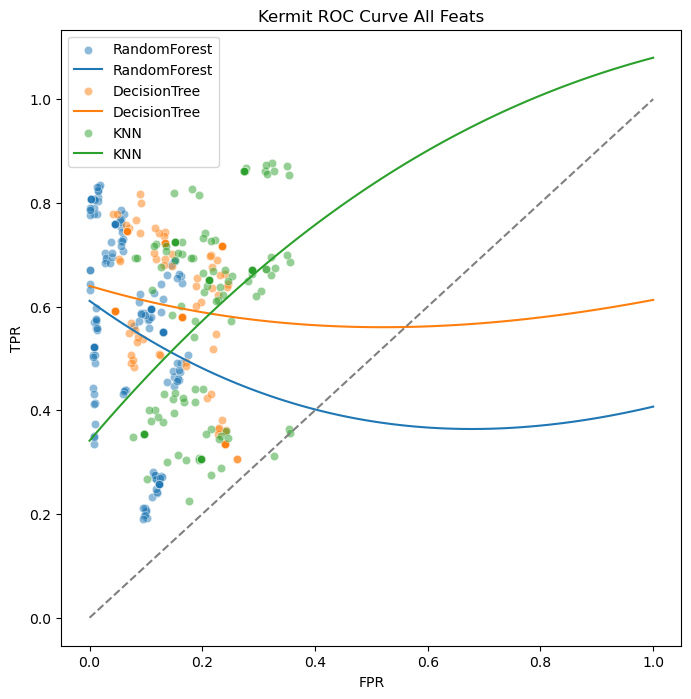

In [163]:
plot_roc_curve(fpr_dict, tpr_dict, model_name, title='Kermit ROC Curve All Feats')

In [ ]:
plot_precision_recall_curve(precision_dict, recall_dict, model_name, title='Gents Precision-Recall Curve All Feats')

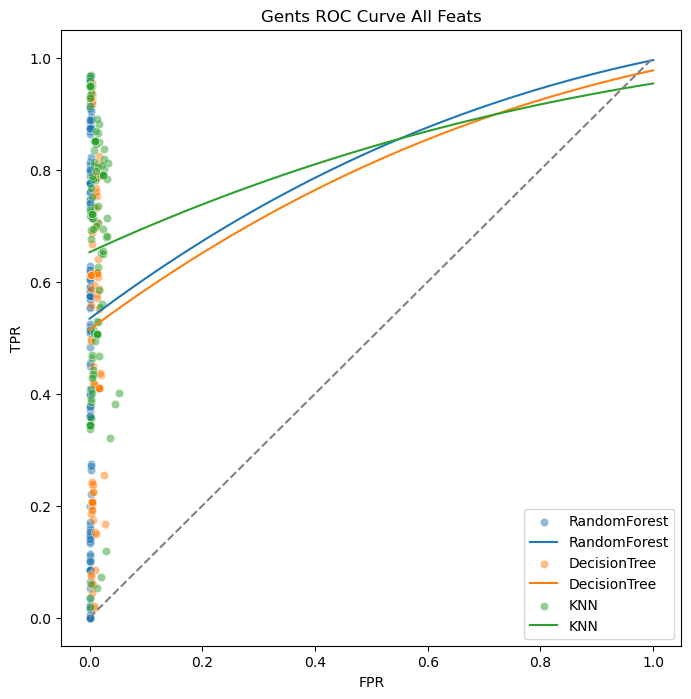

In [71]:
plot_roc_curve(fpr_dict, tpr_dict, model_name, title='Gents ROC Curve All Feats')

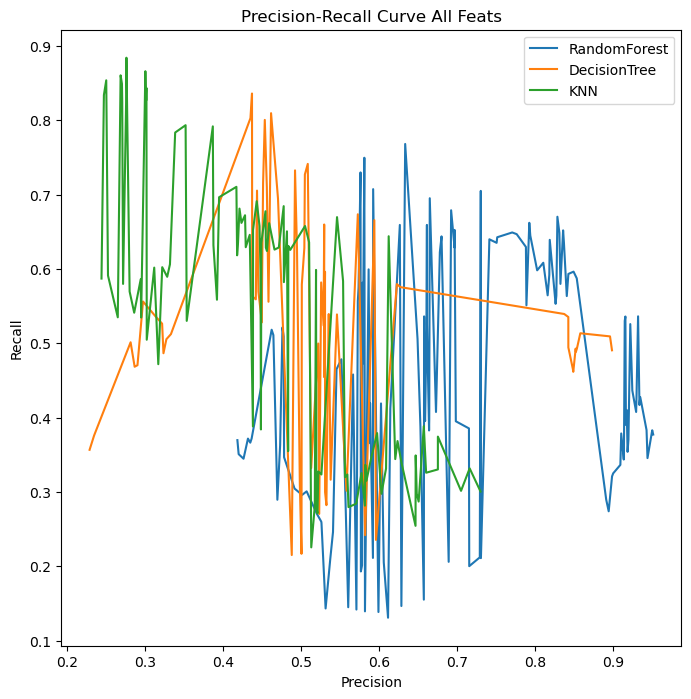

In [58]:
plot_precision_recall_curve(precision_dict, recall_dict, model_name, title='Precision-Recall Curve All Feats')

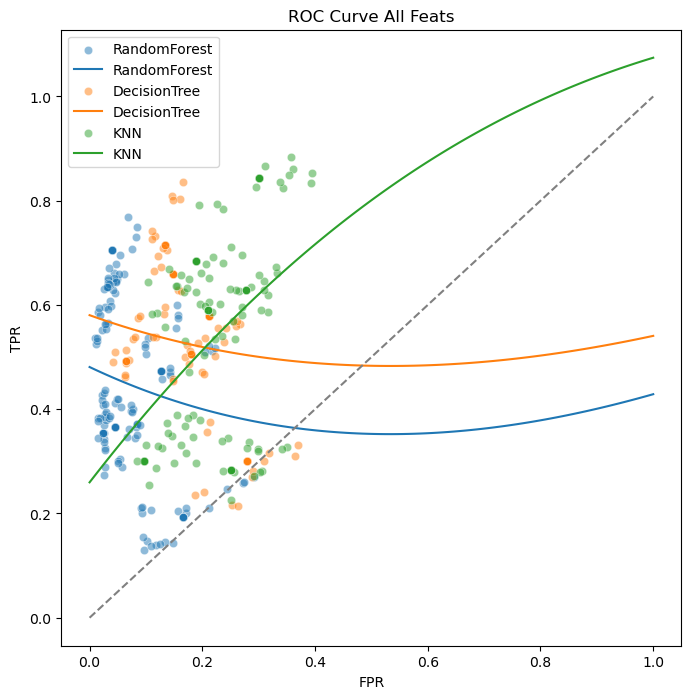

In [59]:
plot_roc_curve(fpr_dict, tpr_dict, model_name, title='ROC Curve All Feats')

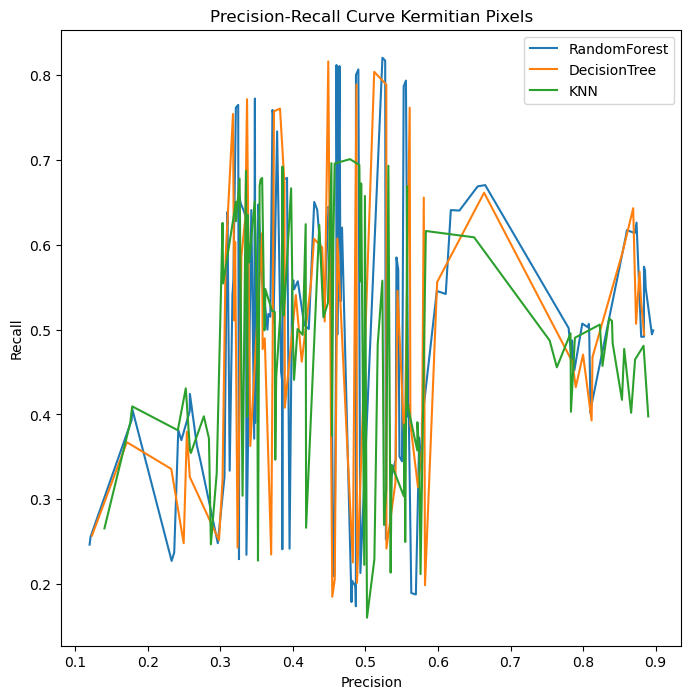

In [97]:
plot_precision_recall_curve(precision_dict, recall_dict, model_name, title='Precision-Recall Curve Kermitian Pixels')

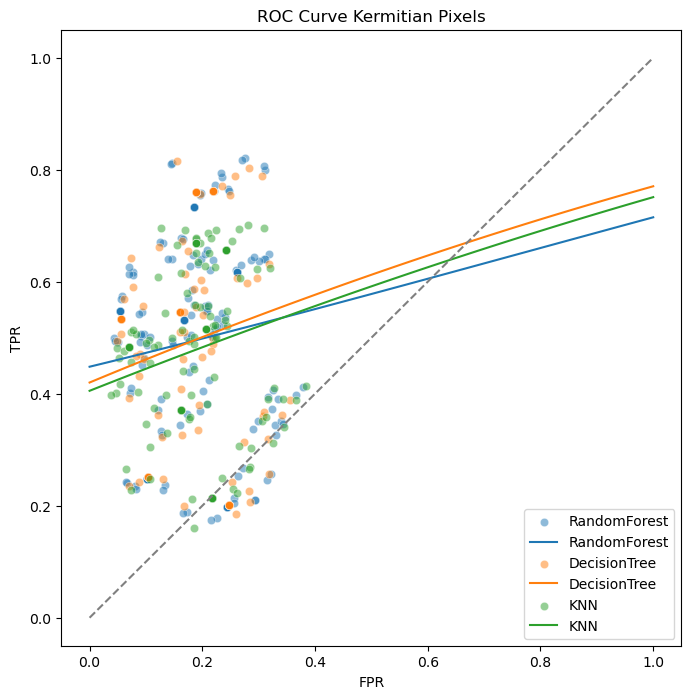

In [98]:
plot_roc_curve(fpr_dict, tpr_dict, model_name, title='ROC Curve Kermitian Pixels')

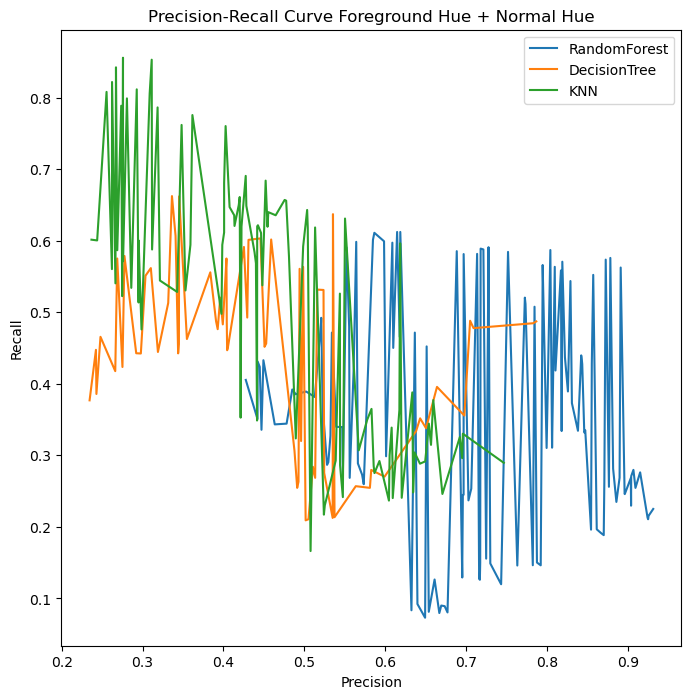

In [48]:
plot_precision_recall_curve(precision_dict, recall_dict, model_name, title='Precision-Recall Curve Foreground Hue + Normal Hue')

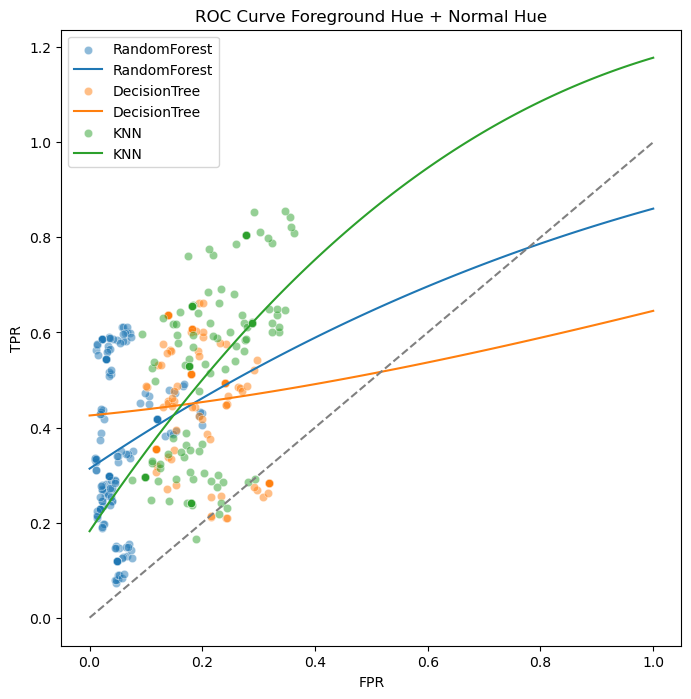

In [49]:
plot_roc_curve(fpr_dict, tpr_dict, model_name, title='ROC Curve Foreground Hue + Normal Hue')

[Text(0.5, 0, 'Precision'),
 Text(0, 0.5, 'Recall'),
 Text(0.5, 1.0, 'Precision-Recall Curve Optical Flow Foreground Hue')]

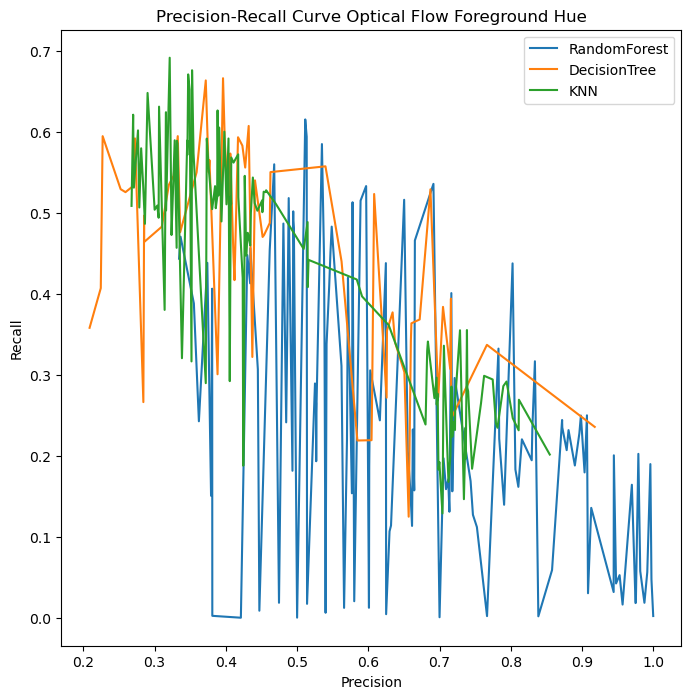

In [230]:
_, ax = plt.subplots(figsize=(8, 8))
for model_name in clf_dict_outer.keys():
    sns.lineplot(x=precision_dict[model_name], y=recall_dict[model_name], label=model_name, ax=ax)
ax.set(xlabel='Precision', ylabel='Recall', title='Precision-Recall Curve Optical Flow Foreground Hue')

<Axes: title={'center': 'ROC Curve Optical Flow Foreground Hue'}, xlabel='FPR', ylabel='TPR'>

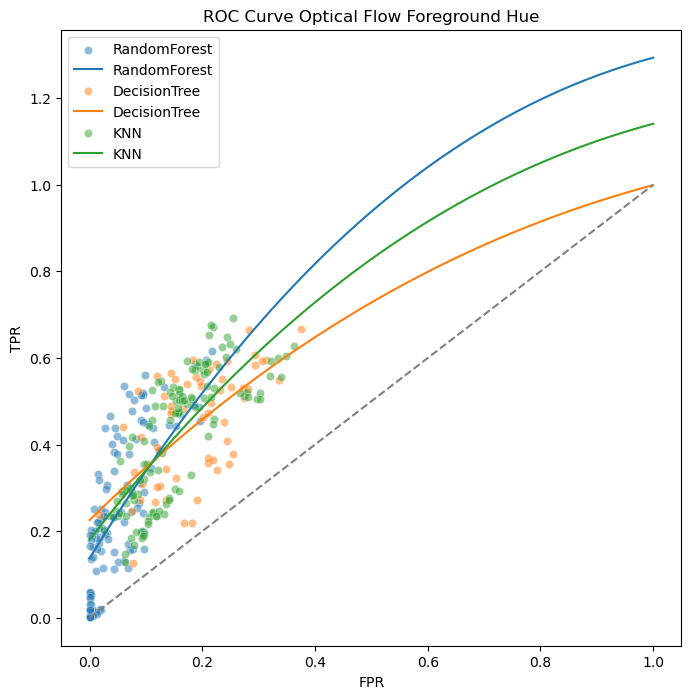

In [233]:
_, ax = plt.subplots(figsize=(8, 8))
for model_name in clf_dict_outer.keys():
    sns.scatterplot(x=fpr_dict[model_name], y=tpr_dict[model_name], label=model_name, ax=ax, alpha=0.5)

    fpr_list = fpr_dict[model_name] + [1, 2, 3, 4, 0]
    tpr_list = tpr_dict[model_name] + [1, 1, 1, 1, 0]

    X = np.array([fpr_list, tpr_list]).T

    coeffs = np.polyfit(X[:, 0], X[:, 1], 3)
    poly_func = np.poly1d(coeffs)

    x_plot = np.linspace(0, 1, 100)
    y_plot = poly_func(x_plot)

    sns.lineplot(x=x_plot, y=y_plot, label=model_name, ax=ax)

ax.set(xlabel='FPR', ylabel='TPR', title='ROC Curve Optical Flow Foreground Hue')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', ax=ax, linestyle='--')

[Text(0.5, 0, 'Precision'),
 Text(0, 0.5, 'Recall'),
 Text(0.5, 1.0, 'Precision-Recall Curve')]

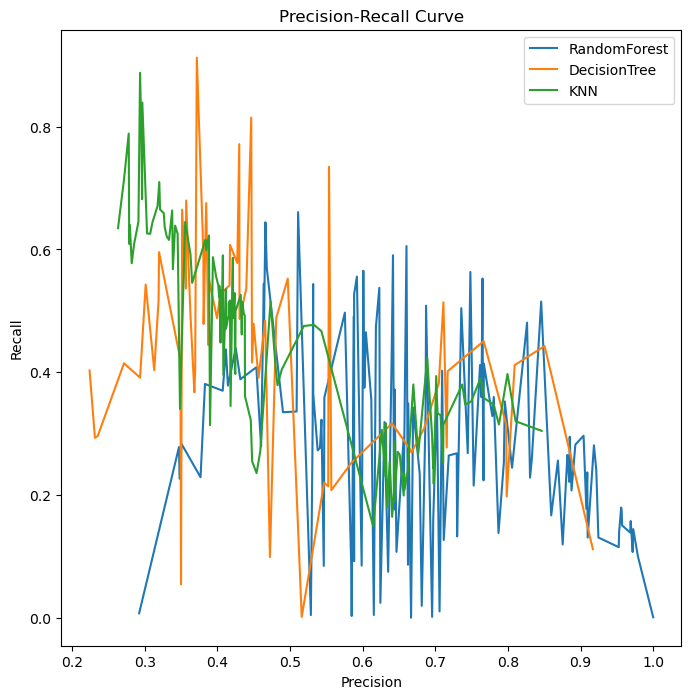

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
for model_name in clf_dict_outer.keys():
    sns.lineplot(x=precision_dict[model_name], y=recall_dict[model_name], label=model_name, ax=ax)
ax.set(xlabel='Precision', ylabel='Recall', title='Precision-Recall Curve')

<Axes: title={'center': 'ROC Curve'}, xlabel='FPR', ylabel='TPR'>

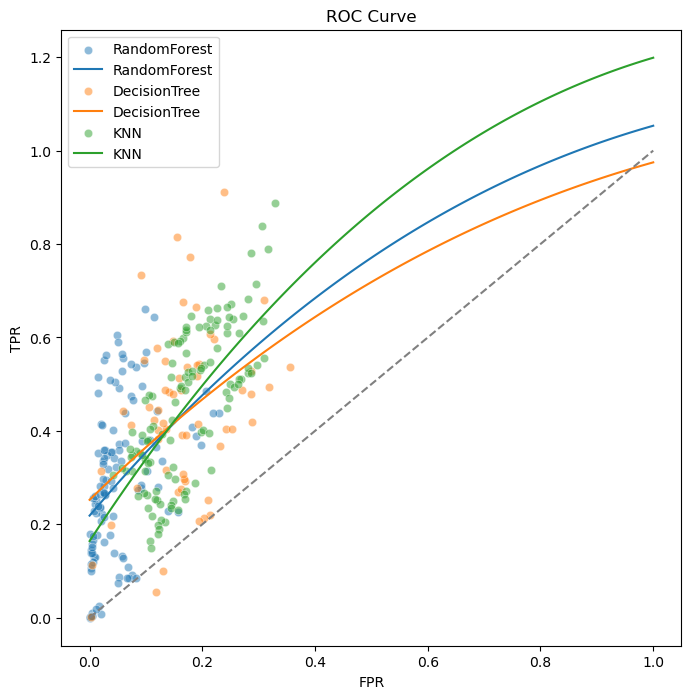

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
for model_name in clf_dict_outer.keys():
    sns.scatterplot(x=fpr_dict[model_name], y=tpr_dict[model_name], label=model_name, ax=ax, alpha=0.5)

    fpr_list = fpr_dict[model_name] + [1]
    tpr_list = tpr_dict[model_name] + [1]

    X = np.array([fpr_list, tpr_list]).T

    coeffs = np.polyfit(X[:, 0], X[:, 1], 3)
    poly_func = np.poly1d(coeffs)

    x_plot = np.linspace(0, 1, 100)
    y_plot = poly_func(x_plot)

    sns.lineplot(x=x_plot, y=y_plot, label=model_name, ax=ax)

ax.set(xlabel='FPR', ylabel='TPR', title='ROC Curve')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', ax=ax, linestyle='--')

<Axes: title={'center': 'ROC Curve'}, xlabel='FPR', ylabel='TPR'>

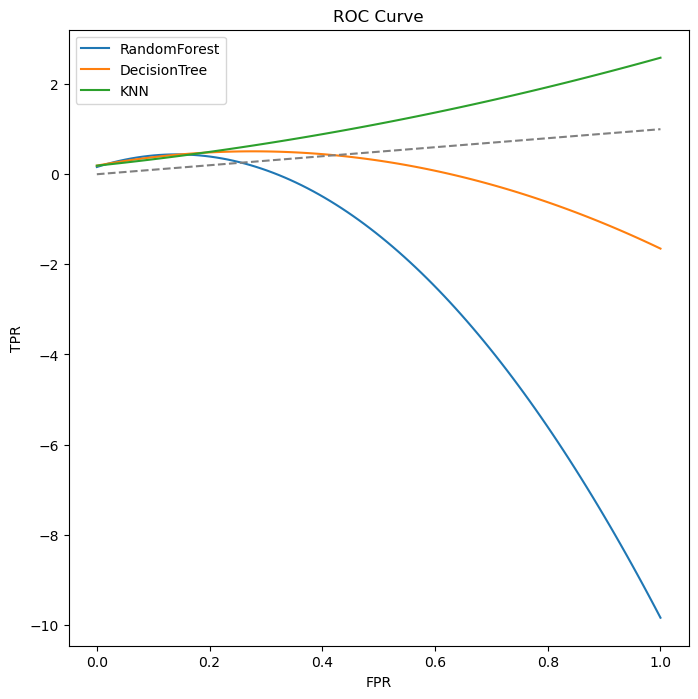

In [197]:
_, ax = plt.subplots(figsize=(8, 8))
for model_name in clf_dict_outer.keys():
    X = np.array([fpr_dict[model_name], tpr_dict[model_name]]).T
    coeffs = np.polyfit(X[:, 0], X[:, 1], 2)
    poly_func = np.poly1d(coeffs)

    x_plot = np.linspace(0, 1, 100)
    y_plot = poly_func(x_plot)

    sns.lineplot(x=x_plot, y=y_plot, label=model_name, ax=ax)
ax.set(xlabel='FPR', ylabel='TPR', title='ROC Curve')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', ax=ax, linestyle='--')